# **Sampling Raster Data**

# **Overview**

Many scientific and environmental datasets come as gridded rasters. If you want to know the value of a variable at a single or multiple locations, you can use sampling techniques to extract the values. XArray has powerful indexing methods that allow us to extract values at multiple coordinates easily. 

In this tutorial, we will take a raster file of temperature anomanies and a CSV file with locations of all urban areas in the US. We will use Pandas and Xarray to find the temperature anomaly at all the urban areas and find the top 10 areas experiencing highest anomaly. We will also use GeoPandas to save the results as a vector layer.

Input Layers:

* `t.anom.202207.tif`: Raster grid of temprature anomaly for the month of July 2022 in the US.
*  `2021_Gaz_ua_national.zip`: A CSV file with point locations representing urban areas in the US.

Output Layers:

*   `tanomaly.gpkg` : A GeoPackage containing a vector layer of point locations with anomaly values sampled from the raster.


Data Credit:

*   [US July 2021 Temperature Anomaly](https://www.cpc.ncep.noaa.gov/products/GIS/GIS_DATA/). NOAA Climate Prediction Center. Retrieved 2022-09

*   [US Gazetteer files: 2021](https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.2021.html) United States Census Bureau. Retrieved 2022-09.


## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !apt install libspatialindex-dev
    !pip install fiona shapely pyproj rtree
    !pip install geopandas
    !pip install rioxarray
    !pip install rasterstats

In [47]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as rxr

In [52]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [49]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

raster_file = 't.anom.202207.tif'
csv_file = '2021_Gaz_ua_national.zip'

files = [
    'https://ftp.cpc.ncep.noaa.gov/GIS/USDM_Products/temp/anom/monthly/' + raster_file,
    'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2021_Gazetteer/' + csv_file,
]

for file in files:
  download(file)

# Procedure

In [13]:
raster_filepath = os.path.join(data_folder, raster_file)
raster = rxr.open_rasterio(raster_filepath, mask_and_scale=True)
raster

<xarray.DataArray (band: 1, y: 32, x: 64)>
array([[[-9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08],
        [-9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08],
        ...,
        [-9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08],
        [-9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -130.0 -129.0 -128.0 -127.0 ... -69.0 -68.0 -67.0
  * y            (y) float64 52.0 51.0 50.0 49.0 48.0 ... 24.0 23.0 22.0 21.0
    spatial_ref  int64 0

In [35]:
nodata = -999000000
raster_masked = raster.where(raster != nodata)
raster_masked

<xarray.DataArray (band: 1, y: 32, x: 64)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -130.0 -129.0 -128.0 -127.0 ... -69.0 -68.0 -67.0
  * y            (y) float64 52.0 51.0 50.0 49.0 48.0 ... 24.0 23.0 22.0 21.0
    spatial_ref  int64 0

In [37]:
tanomaly = raster_masked.sel(band=1)
tanomaly

<xarray.DataArray (y: 32, x: 64)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -130.0 -129.0 -128.0 -127.0 ... -69.0 -68.0 -67.0
  * y            (y) float64 52.0 51.0 50.0 49.0 48.0 ... 24.0 23.0 22.0 21.0
    spatial_ref  int64 0

In [33]:
csv_filepath = os.path.join(data_folder, csv_file)
df  = pd.read_csv(csv_filepath, delimiter = '\t', compression='zip')
df.columns = df.columns.str.replace(' ', '')
df

,GEOID,NAME,UATYPE,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,37,"Abbeville, LA Urban Cluster",C,29189598,298416,11.270,0.115,29.967156,-92.095966
1,64,"Abbeville, SC Urban Cluster",C,11271136,19786,4.352,0.008,34.179273,-82.379776
2,91,"Abbotsford, WI Urban Cluster",C,5426584,13221,2.095,0.005,44.948612,-90.315875
3,118,"Aberdeen, MS Urban Cluster",C,7416338,52820,2.863,0.020,33.824742,-88.554591
4,145,"Aberdeen, SD Urban Cluster",C,33032902,120864,12.754,0.047,45.463186,-98.471033
...,...,...,...,...,...,...,...,...,...
3596,98101,"Zapata--Medina, TX Urban Cluster",C,13451264,0,5.194,0.000,26.889081,-99.266192
3597,98182,"Zephyrhills, FL Urbanized Area",U,112593840,1615599,43.473,0.624,28.285373,-82.198969
3598,98209,"Zimmerman, MN Urban Cluster",C,24456008,2495147,9.443,0.963,45.455850,-93.606705
3599,98236,"Zumbrota, MN Urban Cluster",C,4829469,0,1.865,0.000,44.292793,-92.670931


In [42]:
sampled = tanomaly.sel(x=df.INTPTLONG.to_xarray(), y=df.INTPTLAT.to_xarray(), method='nearest')

In [45]:
df['tanomaly'] = sampled.to_series()
df

,GEOID,NAME,UATYPE,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,tanomaly
0,37,"Abbeville, LA Urban Cluster",C,29189598,298416,11.270,0.115,29.967156,-92.095966,-0.272462
1,64,"Abbeville, SC Urban Cluster",C,11271136,19786,4.352,0.008,34.179273,-82.379776,-0.704404
2,91,"Abbotsford, WI Urban Cluster",C,5426584,13221,2.095,0.005,44.948612,-90.315875,0.130515
3,118,"Aberdeen, MS Urban Cluster",C,7416338,52820,2.863,0.020,33.824742,-88.554591,0.018811
4,145,"Aberdeen, SD Urban Cluster",C,33032902,120864,12.754,0.047,45.463186,-98.471033,1.311932
...,...,...,...,...,...,...,...,...,...,...
3596,98101,"Zapata--Medina, TX Urban Cluster",C,13451264,0,5.194,0.000,26.889081,-99.266192,-1.866690
3597,98182,"Zephyrhills, FL Urbanized Area",U,112593840,1615599,43.473,0.624,28.285373,-82.198969,-0.064647
3598,98209,"Zimmerman, MN Urban Cluster",C,24456008,2495147,9.443,0.963,45.455850,-93.606705,0.607703
3599,98236,"Zumbrota, MN Urban Cluster",C,4829469,0,1.865,0.000,44.292793,-92.670931,0.007632


In [59]:
sorted_df = df.sort_values(by=['tanomaly'], ascending=False)
top10 = sorted_df[['NAME', 'tanomaly']].iloc[:10].reset_index()
top10

,index,NAME,tanomaly
0,2440,"Osburn, ID Urban Cluster",5.214408
1,1634,"Kellogg, ID Urban Cluster",4.543093
2,1839,"Libby, MT Urban Cluster",4.543093
3,336,"Bonners Ferry, ID Urban Cluster",4.487802
4,2431,"Orofino, ID Urban Cluster",4.411723
5,1270,"Grangeville, ID Urban Cluster",4.411723
6,1707,"La Grande, OR Urban Cluster",4.300000
7,172,"Baker City, OR Urban Cluster",4.300000
8,2700,"Rathdrum, ID Urban Cluster",4.138633
9,835,"Deer Park, WA Urban Cluster",4.138633


In [50]:
geometry = gpd.points_from_xy(df.INTPTLONG, df.INTPTLAT)
gdf = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=geometry)
gdf

,GEOID,NAME,UATYPE,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,tanomaly,geometry
0,37,"Abbeville, LA Urban Cluster",C,29189598,298416,11.270,0.115,29.967156,-92.095966,-0.272462,POINT (-92.09597 29.96716)
1,64,"Abbeville, SC Urban Cluster",C,11271136,19786,4.352,0.008,34.179273,-82.379776,-0.704404,POINT (-82.37978 34.17927)
2,91,"Abbotsford, WI Urban Cluster",C,5426584,13221,2.095,0.005,44.948612,-90.315875,0.130515,POINT (-90.31588 44.94861)
3,118,"Aberdeen, MS Urban Cluster",C,7416338,52820,2.863,0.020,33.824742,-88.554591,0.018811,POINT (-88.55459 33.82474)
4,145,"Aberdeen, SD Urban Cluster",C,33032902,120864,12.754,0.047,45.463186,-98.471033,1.311932,POINT (-98.47103 45.46319)
...,...,...,...,...,...,...,...,...,...,...,...
3596,98101,"Zapata--Medina, TX Urban Cluster",C,13451264,0,5.194,0.000,26.889081,-99.266192,-1.866690,POINT (-99.26619 26.88908)
3597,98182,"Zephyrhills, FL Urbanized Area",U,112593840,1615599,43.473,0.624,28.285373,-82.198969,-0.064647,POINT (-82.19897 28.28537)
3598,98209,"Zimmerman, MN Urban Cluster",C,24456008,2495147,9.443,0.963,45.455850,-93.606705,0.607703,POINT (-93.60671 45.45585)
3599,98236,"Zumbrota, MN Urban Cluster",C,4829469,0,1.865,0.000,44.292793,-92.670931,0.007632,POINT (-92.67093 44.29279)


Saving the result to disk as `.gpkg`.

In [53]:
output_filename = 'tanomaly.gpkg'
output_path = os.path.join(output_folder, output_filename)

gdf.to_file(driver='GPKG', filename=output_path)

Let's visualize the results using `tmax` data in a `rainbow` colorRamp.

Text(0.5, 1.0, 'US Maximum Temperature in Celcius')

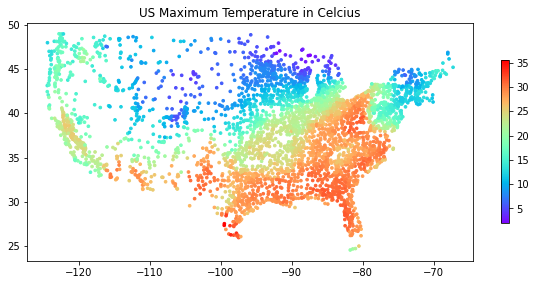

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
urban_places.plot(column = 'tmax', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 7)
ax.set_title('US Maximum Temperature in Celcius')